# Lesson 2 — Linear Regression 

## Outline
This notebook builds linear regression **from scratch** using only NumPy.

We will:
- Load and standardize a real dataset (Energy Efficiency)
- Implement **MSE loss** and its gradient (vectorized)
- Train with **Batch Gradient Descent** and **Stochastic Gradient Descent**
- Compare convergence behavior
- Solve with the **Normal Equation** (closed-form) as a reference
- Visualize model behavior (feature-wise slices)



## Imports

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

np.random.seed(0)

## Data Loading
We use the *Energy Efficiency* dataset.  
Expected CSV schema: 8 features + target.

- `X`: shape `(m, 8)`
- `y`: shape `(m, 1)`


In [28]:
# Update this if your file lives elsewhere
csv_path = Path("../data/energy_efficiency.csv")

if not csv_path.exists():
    raise FileNotFoundError(
        f"Couldn't find {csv_path}. Place the CSV at data/energy_efficiency.csv or update csv_path."
    )

data = np.genfromtxt(csv_path, delimiter=",", skip_header=1)

X_raw = data[:, 0:8]
y = data[:, 8].reshape(-1, 1)

m, n = X_raw.shape
print(f"Loaded: {m} examples, {n} features")

Loaded: 768 examples, 8 features


## Preprocessing: Standardize features + add intercept

In [29]:
# Standardize features: zero mean, unit variance
X = (X_raw - X_raw.mean(axis=0)) / X_raw.std(axis=0)

# Add intercept column
Xb = np.c_[np.ones((m, 1)), X]  # (m, n+1)

print("Xb shape:", Xb.shape, "| y shape:", y.shape)

Xb shape: (768, 9) | y shape: (768, 1)


## Linear Regression Model

### Hypothesis
$$ h_\theta(x) = \theta^T x $$

### Objective (MSE)
We use mean squared error:
$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})^2 $$

### Gradient
Vectorized gradient:
$$ \nabla_\theta J(\theta) = \frac{2}{m} X^T (X\theta - y) $$


In [30]:
def predict(Xb: np.ndarray, theta: np.ndarray) -> np.ndarray:
    return Xb @ theta

def mse_loss(Xb: np.ndarray, y: np.ndarray, theta: np.ndarray) -> float:
    err = predict(Xb, theta) - y
    return float(np.mean(err ** 2))

def mse_gradient(Xb: np.ndarray, y: np.ndarray, theta: np.ndarray) -> np.ndarray:
    m = Xb.shape[0]
    err = predict(Xb, theta) - y
    return (2.0 / m) * (Xb.T @ err)

## Batch Gradient Descent (GD)


In [31]:
def batch_gradient_descent(Xb, y, lr=0.05, epochs=500):
    theta = np.zeros((Xb.shape[1], 1))
    history = []
    for _ in range(epochs):
        history.append(mse_loss(Xb, y, theta))
        theta -= lr * mse_gradient(Xb, y, theta)
    history.append(mse_loss(Xb, y, theta))
    return theta, history

theta_gd, loss_gd = batch_gradient_descent(Xb, y, lr=0.05, epochs=400)
print("Final GD loss:", loss_gd[-1])

Final GD loss: 8.683979562777237


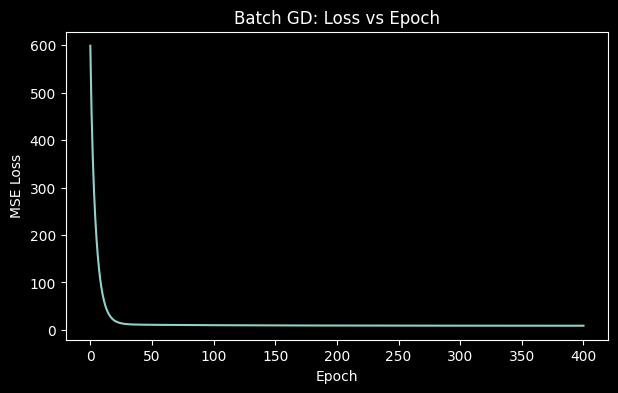

In [32]:
plt.figure(figsize=(7,4))
plt.plot(loss_gd)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Batch GD: Loss vs Epoch")
plt.show()

## Stochastic Gradient Descent (SGD)


In [43]:
def stochastic_gradient_descent(Xb, y, lr=0.01, epochs=50, seed=0):
    n = Xb.shape[0]
    theta = np.zeros((Xb.shape[1], 1))
    rng = np.random.default_rng(seed)
    history = []
    for _ in range(epochs):
        idx = rng.permutation(n)
        for i in idx:
            xi = Xb[i:i+1, :]        # (1, d)
            yi = y[i:i+1, :]         # (1, 1)
            err_i = (xi @ theta) - yi
            grad_i = 2.0 * xi.T * err_i  # (d,1)
            theta -= lr * grad_i
        history.append(mse_loss(Xb, y, theta))
    return theta, history

theta_sgd, loss_sgd = stochastic_gradient_descent(Xb, y, lr=0.01, epochs=60, seed=0)
print("Final SGD loss:", loss_sgd[-1])

Final SGD loss: 9.96421770546605


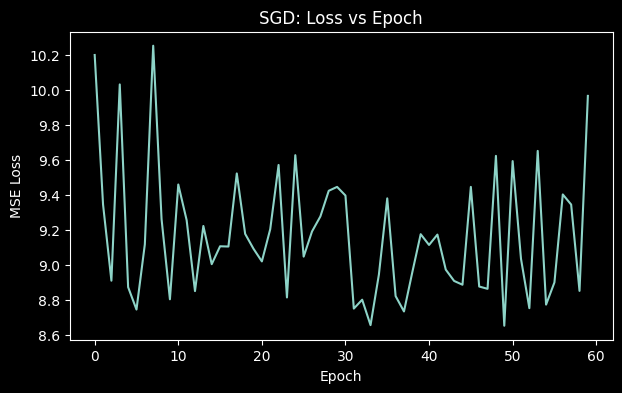

In [44]:
plt.figure(figsize=(7,4))
plt.plot(loss_sgd)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("SGD: Loss vs Epoch")
plt.show()

## Compare GD vs SGD (Convergence)

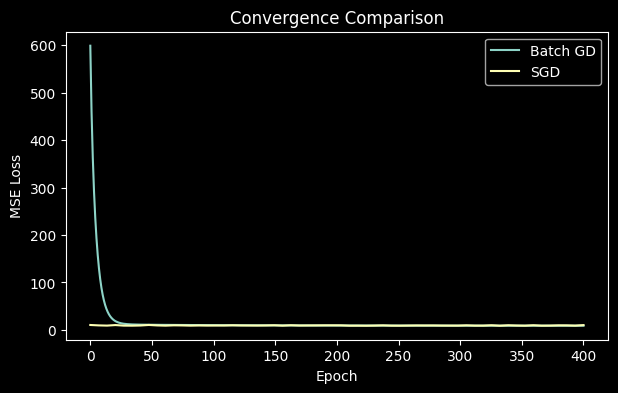

In [45]:
plt.figure(figsize=(7,4))
plt.plot(loss_gd, label="Batch GD")
plt.plot(np.linspace(0, len(loss_gd)-1, len(loss_sgd)), loss_sgd, label="SGD")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Convergence Comparison")
plt.legend()
plt.show()

## Normal Equation

For linear regression, the global minimizer is:

$$ \theta = (X^T X)^{-1} X^T y $$

We use the pseudo-inverse for stability:
$$ \theta = X^+ y $$


In [36]:
theta_ne = np.linalg.pinv(Xb) @ y
loss_ne = mse_loss(Xb, y, theta_ne)
print("Normal Equation loss:", loss_ne)

Normal Equation loss: 8.520534385774404


## Feature-wise Visualization

Because this is an 8-feature model, a single line can't represent the full fit in 8D.  
Instead, we visualize **feature-wise slices**: we vary one feature while holding all others at 0 (mean after standardization).

This is a helpful way to see the **direction and strength** of each coefficient.


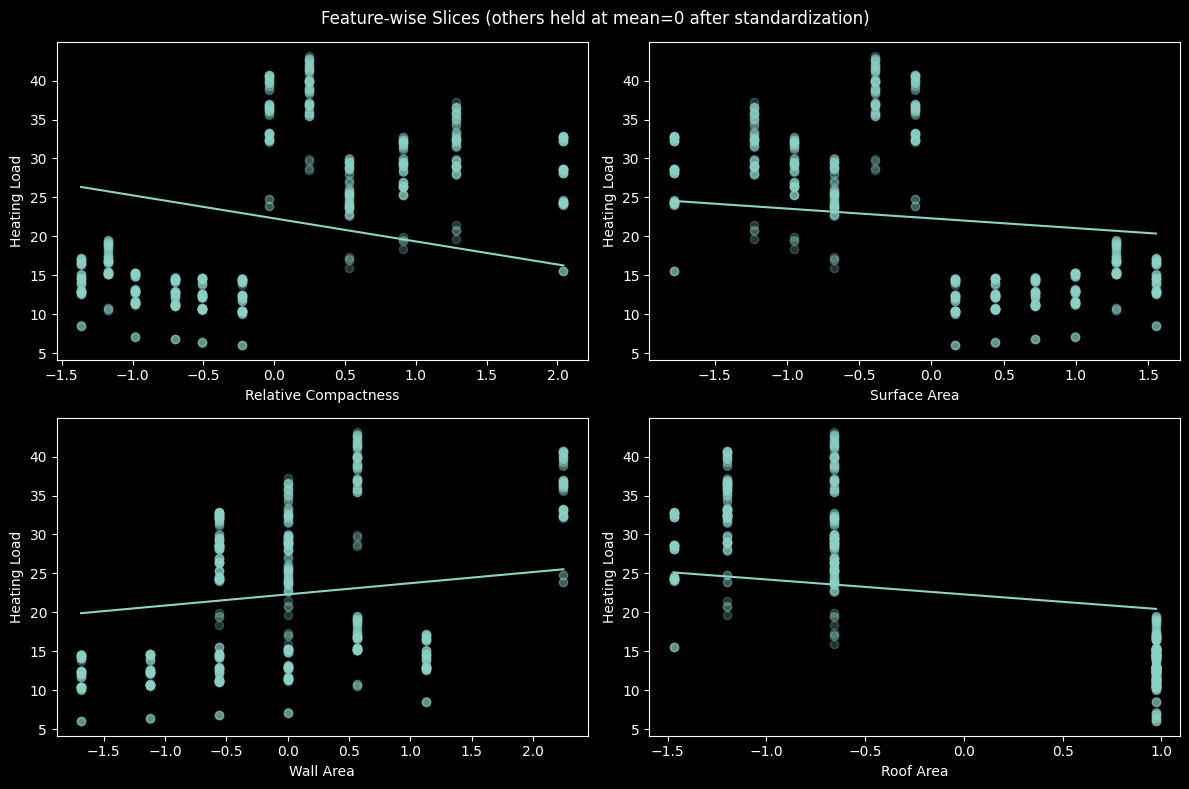

In [38]:
feature_names = [
    "Relative Compactness",
    "Surface Area",
    "Wall Area",
    "Roof Area",
    "Overall Height",
    "Orientation",
    "Glazing Area",
    "Glazing Area Distribution",
]

theta_use = theta_gd  # switch to theta_ne if you'd like

plt.figure(figsize=(12,8))
for idx, j in enumerate(range(4)):  # first 4 features, like your original
    X_feat = X[:, j].reshape(-1, 1)

    x_line = np.linspace(X_feat.min(), X_feat.max(), 200).reshape(-1, 1)
    Xb_line = np.zeros((len(x_line), Xb.shape[1]))
    Xb_line[:, 0] = 1
    Xb_line[:, j+1] = x_line[:, 0]

    y_line = Xb_line @ theta_use

    plt.subplot(2,2,idx+1)
    plt.scatter(X_feat, y, alpha=0.25)
    plt.plot(x_line, y_line)
    plt.xlabel(feature_names[j])
    plt.ylabel("Heating Load")

plt.suptitle("Feature-wise Slices (others held at mean=0 after standardization)")
plt.tight_layout()
plt.show()

## Key Insights

- **Batch GD**: stable, smooth convergence; requires learning rate tuning; each epoch is expensive for large datasets.
- **SGD**: noisy updates; typically faster progress early; useful at scale and for streaming data.
- **Normal Equation**: direct global optimum for linear regression; can be expensive/unreliable for huge feature spaces.

**Most important takeaway:**  
Linear regression is a convex optimization problem with a unique global minimum.  
Gradient-based methods *approach* it; the normal equation *jumps* to it (when feasible).
